<a href="https://colab.research.google.com/github/Duffany/emines_ts/blob/master/Doufani_auscafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5MB 8.9MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
#import libraries

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline


import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/mlmarenchino/forecasting/master/data/auscafe.csv')

In [8]:
print(df.shape)
df.sample(5)

(426, 2)


,index,value
164,1995 Dec,1.3147
129,1993 Jan,0.9178
30,1984 Oct,0.4245
74,1988 Jun,0.6355
65,1987 Sep,0.5927


In [9]:
#check for Nans
#nombre des valeurs manquantes dans chaque colonne
df_null =df.isnull().sum(); pr=df.isnull().sum()/len(df['index'])
Nan= pd.concat([df_null,pr], axis=1, keys=["df" ,"pourcentage (%)"]) ; Nan

,df,pourcentage (%)
index,0,0.0
value,0,0.0


In [11]:
#set a propre format for date

from dateutil import parser

df['date'] = df['index'].apply(lambda d : parser.parse(d))
df.drop('index', axis=1, inplace=True)

df.head()

,value,date
0,0.3424,1982-04-27
1,0.3421,1982-05-27
2,0.3287,1982-06-27
3,0.3385,1982-07-27
4,0.3315,1982-08-27


# Transformer en pd.Series avec les dates pour index

In [12]:
ts = pd.Series(data = df['value'].values, index = df['date'])
ts


date
1982-04-27    0.3424
1982-05-27    0.3421
1982-06-27    0.3287
1982-07-27    0.3385
1982-08-27    0.3315
               ...  
2017-05-27    3.5986
2017-06-27    3.5442
2017-07-27    3.6981
2017-08-27    3.7112
2017-09-27    3.7297
Length: 426, dtype: float64

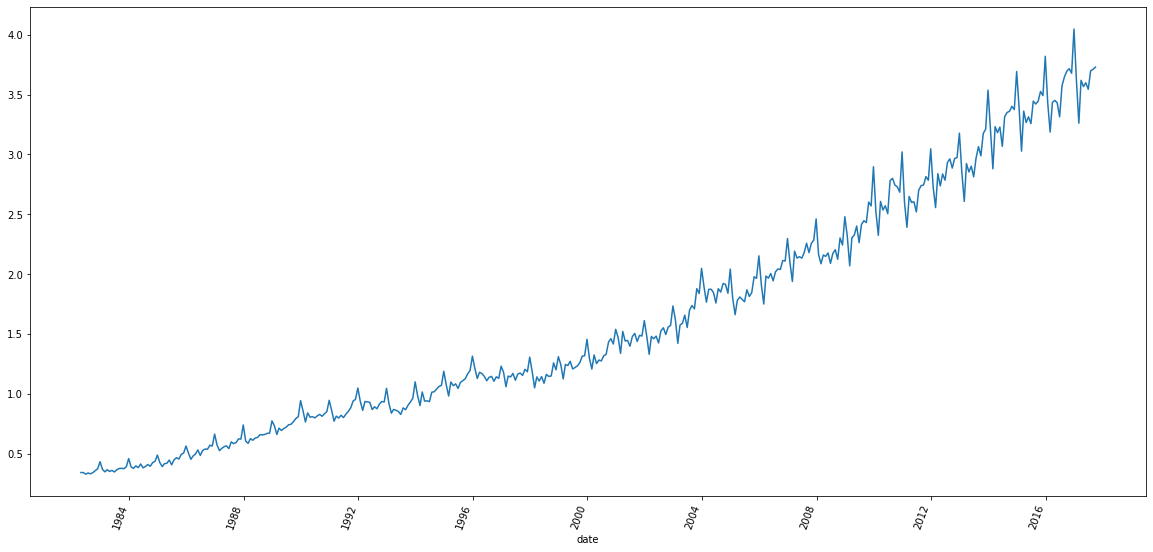

In [13]:
plt.figure(figsize=(20,10))
ts.plot()
plt.xticks(rotation=70)
plt.show()

##**White noise ?**

In [17]:
#Ljung-Box test
import statsmodels.api as sm

#fit ARMA model to dataset
res = sm.tsa.ARMA(ts, (1,1)).fit(disp=-1)

#perform Ljung-Box test on residuals with lag=10
sm.stats.acorr_ljungbox(res.resid, lags=[10])

(array([6.81649304e-05]), array([1.]))

##**Stationary ?**

In [19]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


res1= adfuller(ts)

print(f"la p-value est {res1[1]} > 0.05 donc on peut pas  rejeter H0: a unit root is present in a time series sample  ")


res2 = kpss(ts)
print(f"la p-value est {res2[1]} < 0.05 donc on peut pas rejeter H0: time series is not stationary ")

la p-value est 1.0 > 0.05 donc on peut pas  rejeter H0: a unit root is present in a time series sample  
la p-value est 0.01 < 0.05 donc on peut pas rejeter H0: time series is not stationary 


##**Autocorrelation and Partial Autocorrelation**

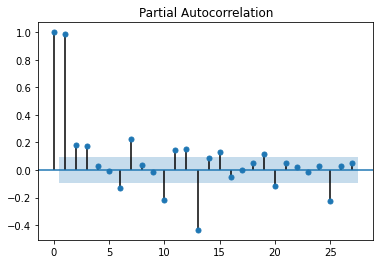

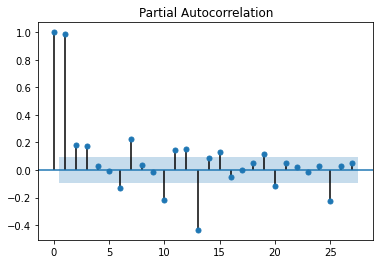

In [20]:
import statsmodels.tsa.api as smt
smt.graphics.plot_pacf(ts.values)


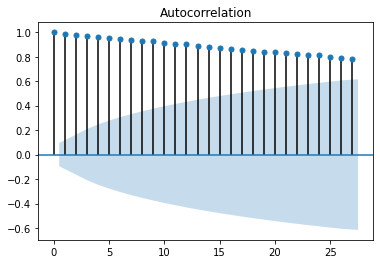

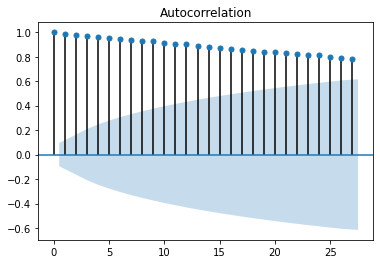

In [21]:
smt.graphics.plot_acf(ts.values)

# Differenciation

https://machinelearningmastery.com/difference-time-series-dataset-python/


In [ ]:
?ts.diff()

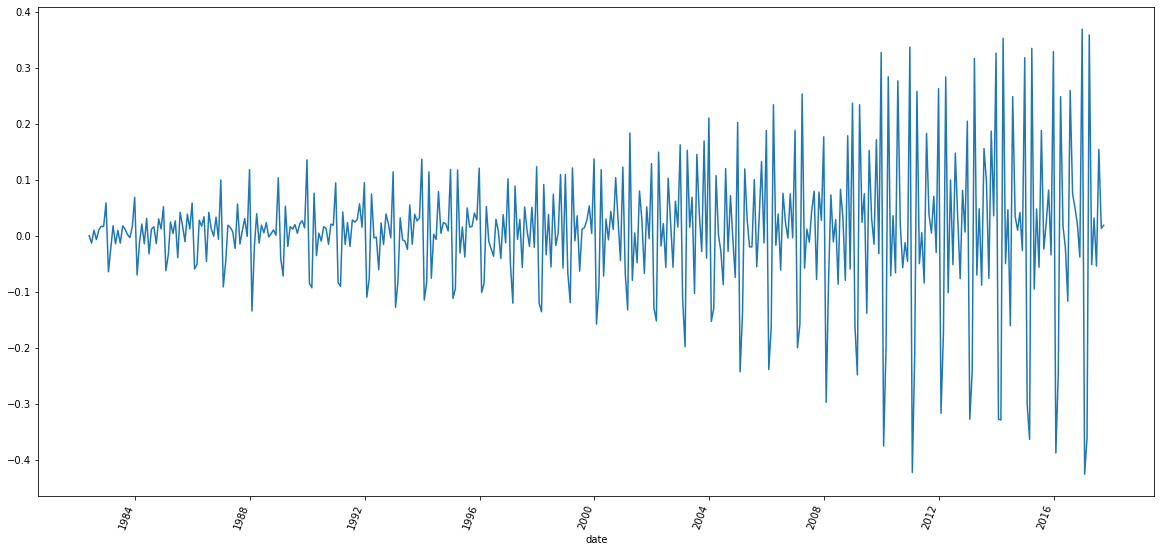

In [22]:
plt.figure(figsize=(20,10))
ts.diff().plot()
plt.xticks(rotation=70)
plt.show()


In [23]:
d1 = ts.diff()
d1 = d1[~d1.isna()]

In [24]:
d1

date
1982-05-27   -0.0003
1982-06-27   -0.0134
1982-07-27    0.0098
1982-08-27   -0.0070
1982-09-27    0.0104
               ...  
2017-05-27    0.0316
2017-06-27   -0.0544
2017-07-27    0.1539
2017-08-27    0.0131
2017-09-27    0.0185
Length: 425, dtype: float64

In [25]:
res = adfuller(d1)

print(f"la p-value est {res[1]} << 0.05 donc on peut rejeter H0: a unit root is present in a time series sample  ")

# => stationnaire avec adfuller


res = kpss(d1)
print(f"la p-value est {res[1]} > 0.05 donc on peut pas rejeter H0: time series is stationary ")

la p-value est 3.9163470878830243e-07 << 0.05 donc on peut rejeter H0: a unit root is present in a time series sample  
la p-value est 0.08899727534513902 > 0.05 donc on peut pas rejeter H0: time series is stationary 


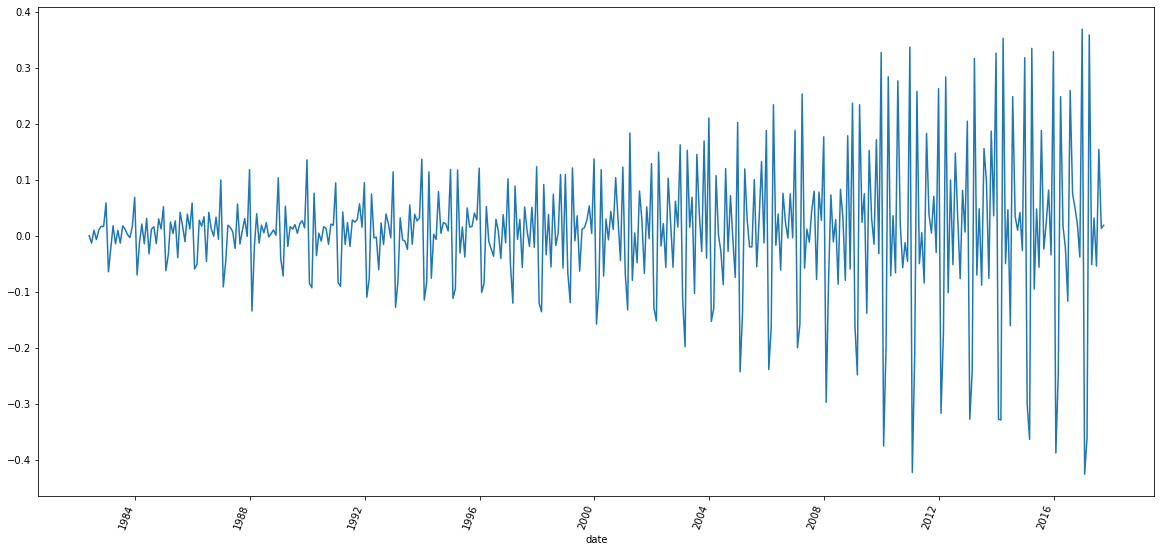

In [26]:
plt.figure(figsize=(20,10))
d1.plot()
plt.xticks(rotation=70)
plt.show()

##**ARIMA**

In [28]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from itertools import product 

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [29]:
#select the best order for the ARIMA model

def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the ts
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = smt.ARIMA(exog, order=order).fit(ic ='aic',trend='nc',disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df




In [30]:
ps = range(7)
d = 1
qs = range(7)
# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=d1.values)
result_df

,"(p, d, q)",AIC
0,"(6, 1, 2)",-821.331760
1,"(6, 1, 1)",-804.224924
2,"(5, 1, 2)",-803.964473
3,"(4, 1, 2)",-778.665375
4,"(1, 1, 5)",-776.010038
5,"(3, 1, 3)",-772.411494
6,"(1, 1, 3)",-765.291786
7,"(1, 1, 4)",-763.828802
8,"(3, 1, 2)",-720.498691
9,"(3, 1, 1)",-709.423951


In [32]:
best_model = smt.ARIMA(d1.values, order=(6, 0, 2)).fit()
print(best_model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  425
Model:                     ARMA(6, 2)   Log Likelihood                 441.873
Method:                       css-mle   S.D. of innovations              0.085
Date:                Wed, 27 Jan 2021   AIC                           -863.746
Time:                        22:50:20   BIC                           -823.225
Sample:                             0   HQIC                          -847.738
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0079      0.001      7.873      0.000       0.006       0.010
ar.L1.y       -0.2917      0.060     -4.825      0.000      -0.410      -0.173
ar.L2.y       -0.0281      0.063     -0.444      0.6

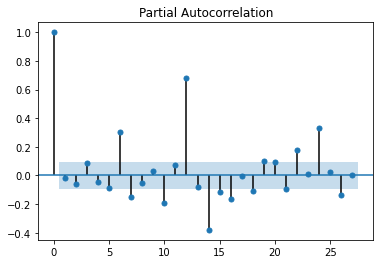

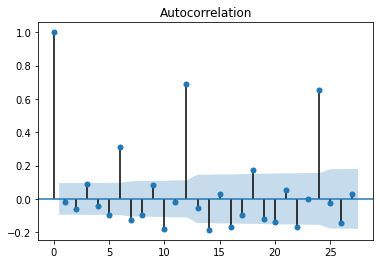

In [33]:
plot_pacf(best_model.resid);
plot_acf(best_model.resid);

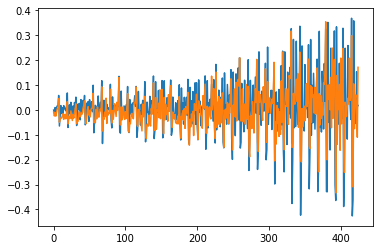

In [34]:
plt.plot(d1.values)
plt.plot(best_model.resid)


##**Time Series Components**

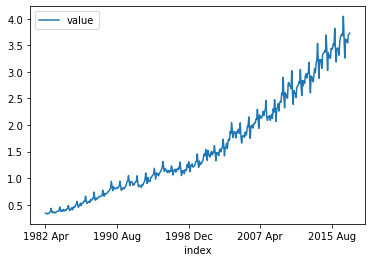

In [2]:
from matplotlib import pyplot
series = pd.read_csv('https://raw.githubusercontent.com/mlmarenchino/forecasting/master/data/auscafe.csv', header=0, index_col=0)
series.plot()
pyplot.show()

In [3]:
series.head()

,value
index,
1982 Apr,0.3424
1982 May,0.3421
1982 Jun,0.3287
1982 Jul,0.3385
1982 Aug,0.3315


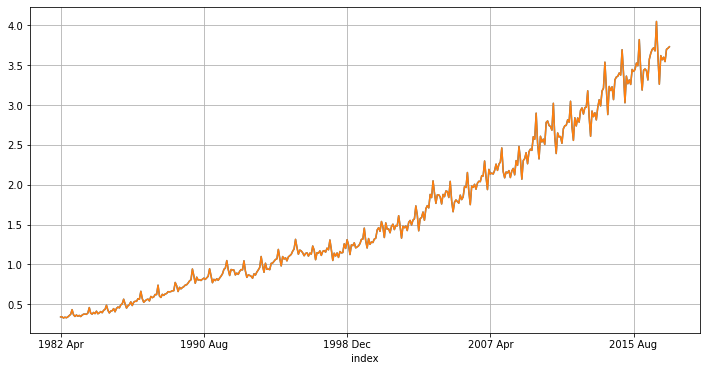

In [4]:
ts = pd.Series(data = series['value'].values, index = series.index)

ts = ts[~ts.isna()]
ts.plot(figsize= (12,6), grid = True)
plt.plot(ts.index, ts.values)

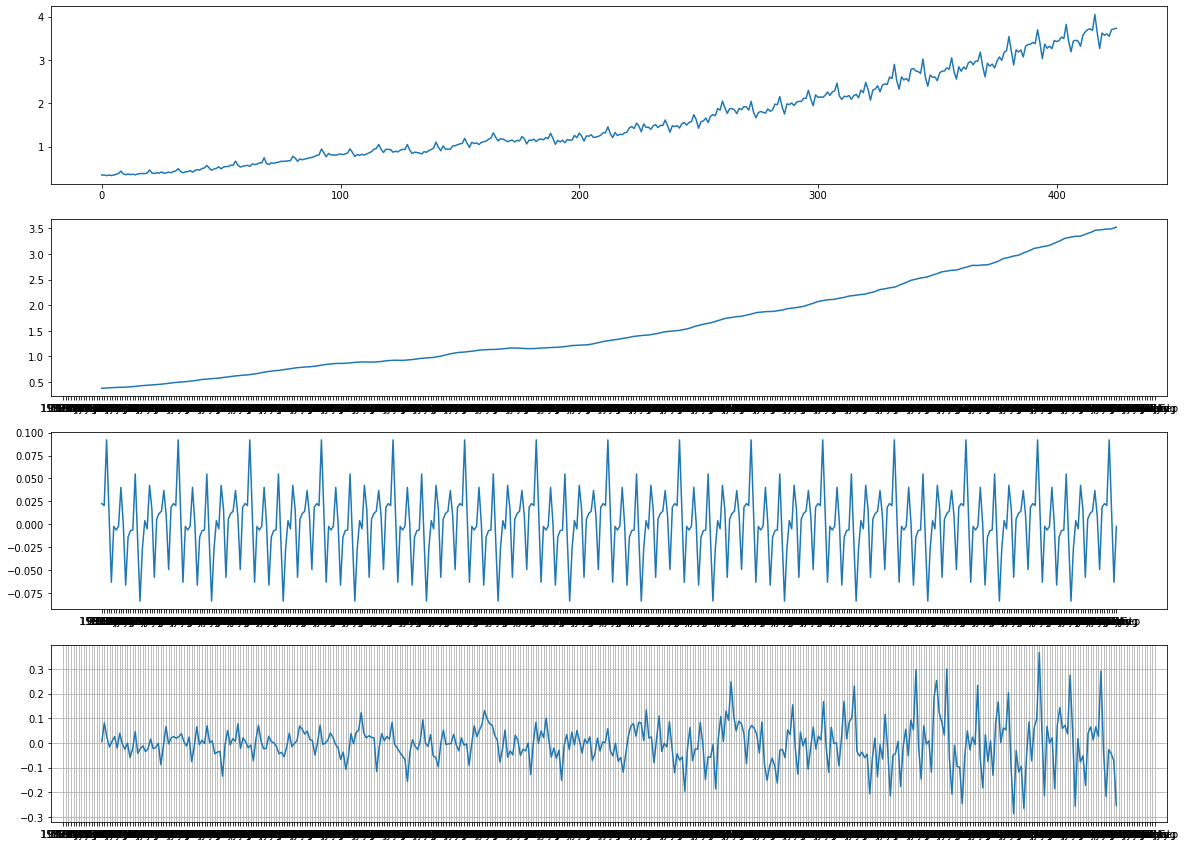

In [11]:
#additive model
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts, model='additive',period = 30)
fig, ax = plt.subplots(4,1, figsize = (20,15))
plt.subplot(4,1,1)
plt.plot(ts.values)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.subplot(4,1,4)
plt.plot(result.resid)
plt.grid()


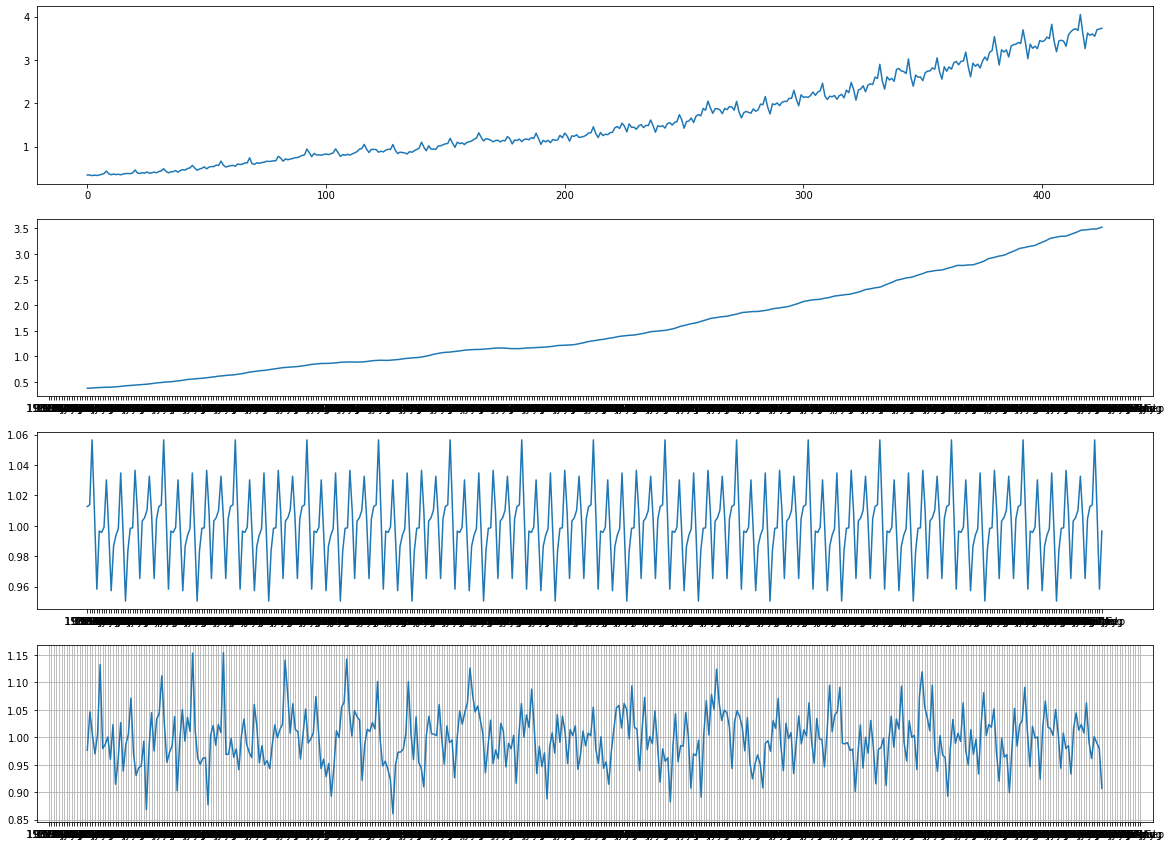

In [13]:
#multiplicative model

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(ts, model='multiplicative',period = 30)
fig, ax = plt.subplots(4,1, figsize = (20,15))
plt.subplot(4,1,1)
plt.plot(ts.values)
plt.subplot(4,1,2)
plt.plot(result.trend)
plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.subplot(4,1,4)
plt.plot(result.resid)
plt.grid()


In [14]:
#try TLS
from statsmodels.tsa.seasonal import STL

ts.asfreq('MS')

index
1982-04-01    0.3424
1982-05-01    0.3421
1982-06-01    0.3287
1982-07-01    0.3385
1982-08-01    0.3315
               ...  
2017-05-01    3.5986
2017-06-01    3.5442
2017-07-01    3.6981
2017-08-01    3.7112
2017-09-01    3.7297
Freq: MS, Length: 426, dtype: float64

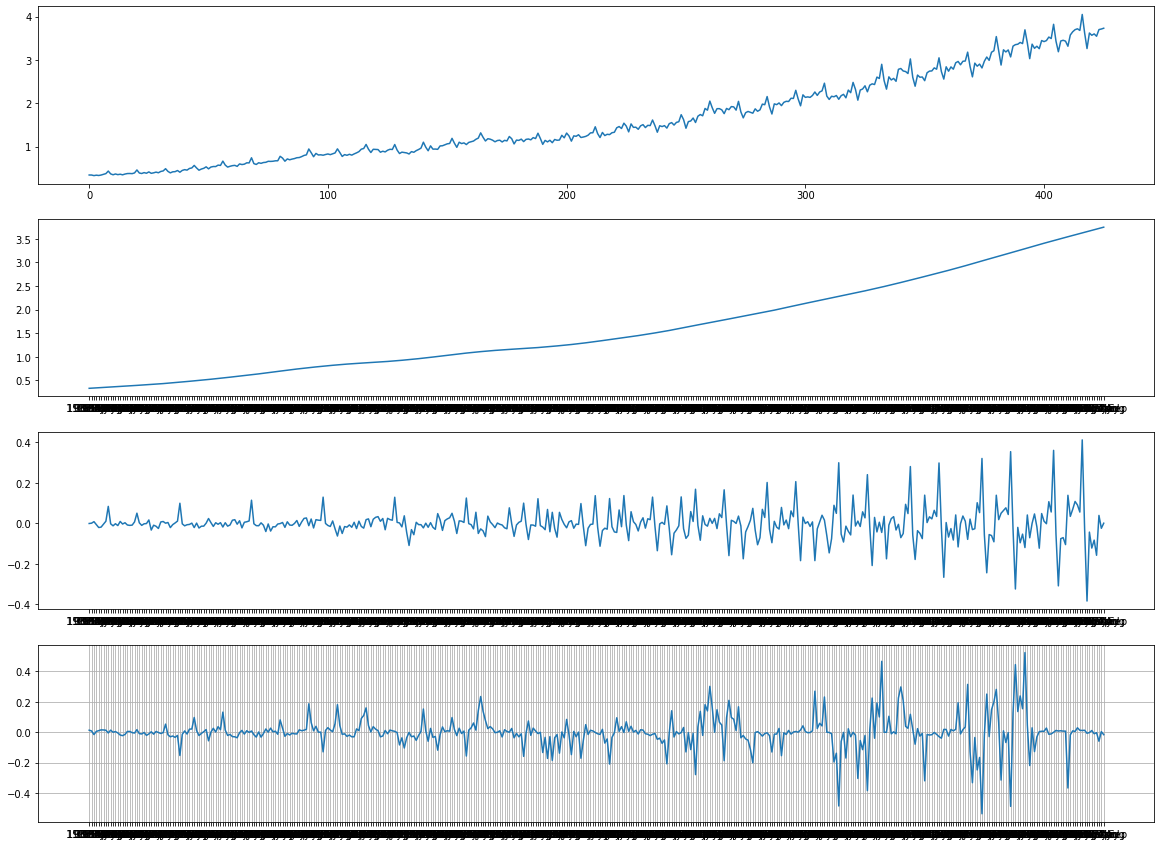

In [15]:
res = STL(ts, robust = True, period = 30).fit() #period de 30 jours = un mois
fig, ax = plt.subplots(4,1, figsize = (20,15))
plt.subplot(4,1,1)
plt.plot(ts.values)
plt.subplot(4,1,2)
plt.plot(res.trend)
plt.subplot(4,1,3)
plt.plot(res.seasonal)
plt.subplot(4,1,4)
plt.plot(res.resid)
plt.grid()


(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

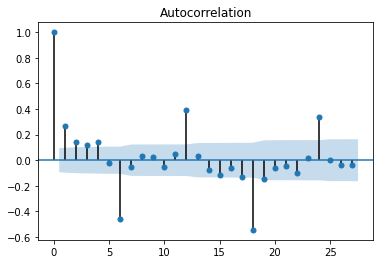

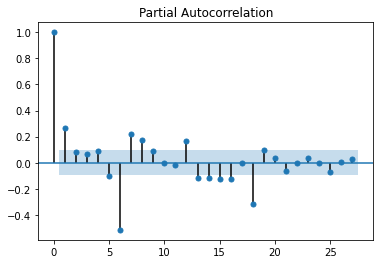

In [18]:
plot_acf(res.resid),plot_pacf(res.resid)